<a href="https://colab.research.google.com/github/biga-bojana/formality-evaluation-task/blob/main/formality_evaluation_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q datasets pandas

In [6]:
from datasets import load_dataset
import pandas as pd
import random

# Load Informal Data

# DailyDialog
daily_dialog = load_dataset("daily_dialog", split="train", trust_remote_code=True)
daily_texts = []
for dialog in daily_dialog["dialog"]:
    daily_texts.extend(dialog)
random.shuffle(daily_texts)
informal_dialogs = daily_texts[:40]

# TweetEval: social media language
tweet_eval = load_dataset("tweet_eval", "emotion", split="train", trust_remote_code=True)
tweet_texts = tweet_eval["text"]
random.shuffle(tweet_texts)
informal_tweets = tweet_texts[:40]

# Combine both
informal_texts = informal_dialogs + informal_tweets
df_informal = pd.DataFrame({
    "text": informal_texts,
    "label": ["informal"] * len(informal_texts)
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Load Enron from direct .parquet link
enron_url = "https://huggingface.co/datasets/amanneo/enron-mail-corpus-mini/resolve/main/data/train-00000-of-00001-014f331c4b4820b4.parquet"
df_enron = pd.read_parquet(enron_url)

# Take first 80 for formal class
df_formal = pd.DataFrame({
    "text": df_enron["text"].tolist()[:80],
    "label": ["formal"] * 80
})


In [8]:
# Combine and shuffle
df_combined = pd.concat([df_formal, df_informal], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# Preview the dataset
df_combined.head()


,text,label
0,"During the days of my absence from office, I c...",formal
1,All hell is breaking loose in Charlotte. #Char...,informal
2,is it bad that kurt is literally me..? #glee,informal
3,"As a graduate , it may be more important to d...",informal
4,"If you have time, please could you listen to m...",formal


In [9]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define evaluation function
def evaluate_model(model_name_or_path, texts, labels, label_map=None, title_suffix=""):
    clf = pipeline("text-classification", model=model_name_or_path)

    predictions = []
    for text in texts:
        try:
            output = clf(text)[0]
            label = output['label'].lower()
            if label_map:
                label = label_map.get(label, label)
            predictions.append(label)
        except Exception as e:
            print(f"Failed on input: {text[:30]}... Error: {e}")
            predictions.append("error")

    print(f"\nEvaluation for model: {model_name_or_path}")
    print("Accuracy:", accuracy_score(labels, predictions))
    print("\nClassification report:\n", classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions, labels=sorted(set(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix: {title_suffix or model_name_or_path}")
    plt.show()

    return predictions


In [17]:
texts = df_combined["text"].tolist()
labels = df_combined["label"].tolist()



In [11]:
!pip install transformers

In [12]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_with_neutral_remap(model_name_or_path, texts, labels, title_suffix=""):
    clf = pipeline("text-classification", model=model_name_or_path)

    raw_preds = []
    for text in texts:
        try:
            output = clf(text)[0]
            label = output['label'].lower()
            if label == "neutral":
                label = "formal"  # remap neutral → formal
            raw_preds.append(label)
        except Exception as e:
            print(f"Failed on input: {text[:30]}... Error: {e}")
            raw_preds.append("error")

    print(f"\nEvaluation for model: {model_name_or_path} (Neutral → Formal)")
    print("Accuracy:", accuracy_score(labels, raw_preds))
    print("\n Classification report:\n", classification_report(labels, raw_preds))

    cm = confusion_matrix(labels, raw_preds, labels=sorted(set(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix: {title_suffix or model_name_or_path} (Neutral → Formal)")
    plt.show()

    return raw_preds


Device set to use cpu



Evaluation for model: LenDigLearn/formality-classifier-mdeberta-v3-base (Neutral → Formal)
Accuracy: 0.8875

 Classification report:
               precision    recall  f1-score   support

      formal       0.82      1.00      0.90        80
    informal       1.00      0.78      0.87        80

    accuracy                           0.89       160
   macro avg       0.91      0.89      0.89       160
weighted avg       0.91      0.89      0.89       160



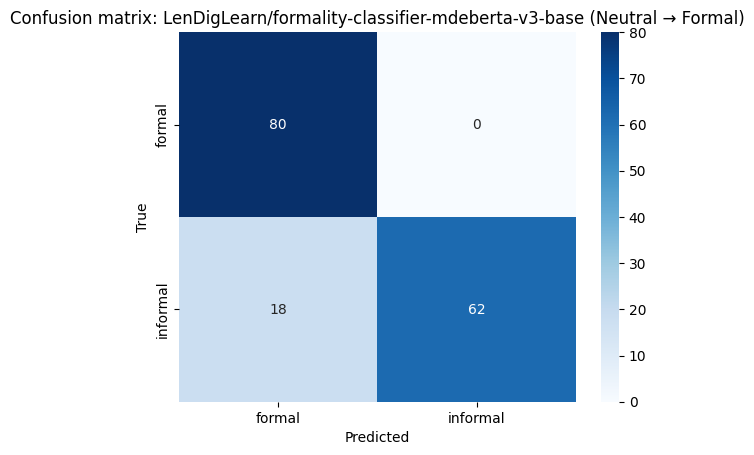

In [13]:
preds_deberta = evaluate_model_with_neutral_remap(
    "LenDigLearn/formality-classifier-mdeberta-v3-base",
    df_combined["text"].tolist(),
    df_combined["label"].tolist()
)


In [ ]:
from transformers import pipeline

# Use open-source Falcon 7B Instruct (no authentication needed)
llm_judge = pipeline(
    "text-generation",
    model="tiiuae/falcon-7b-instruct",
    max_new_tokens=20,
    do_sample=False
)

# Simple LLM-as-a-Judge (returns only Correct/Incorrect)
def llm_as_judge_trimmed(sentences, model_preds):
    results = []
    for sent, pred in zip(sentences, model_preds):
        prompt = f"""You are a formality expert.

Sentence: "{sent}"
Model prediction: "{pred}"

Is this label correct? Reply only with "Correct" or "Incorrect".
Answer:"""
        try:
            output = llm_judge(prompt)[0]["generated_text"]
            # Extract only the first word to keep it trimmed
            judgment = output.split("Answer:")[-1].strip().split()[0]
        except Exception as e:
            judgment = "Error"
            print(f"Failed on: {sent[:30]}...")

        results.append({
            "sentence": sent,
            "model_label": pred,
            "llm_judgment": judgment
        })
    return results


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
judged_trimmed = llm_as_judge_trimmed(texts[:5], preds_deberta[:5])
for item in judged_trimmed:
    print(item)


NameError: name 'llm_as_judge_trimmed' is not defined

In [18]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_zero_shot_model(model_name, texts, labels, candidate_labels=["formal", "informal"], title_suffix=""):
    clf = pipeline("zero-shot-classification", model=model_name)

    predictions = []
    for text in texts:
        try:
            result = clf(text, candidate_labels=candidate_labels)
            predicted_label = result["labels"][0].lower()
            predictions.append(predicted_label)
        except Exception as e:
            print(f"Failed on: {text[:30]}... Error: {e}")
            predictions.append("error")

    print(f"\n Zero-shot evaluation: {model_name}")
    print("Accuracy:", accuracy_score(labels, predictions))
    print("\nClassification Report:\n", classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions, labels=sorted(set(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix: {title_suffix or model_name}")
    plt.show()

    return predictions


In [31]:
del texts
del labels

In [32]:
texts = df_combined["text"].tolist()
labels = df_combined["label"].tolist()


Device set to use cpu



📊 Zero-shot evaluation: MoritzLaurer/deberta-v3-base-zeroshot-v2.0
✅ Accuracy: 0.74375

📋 Classification Report:
               precision    recall  f1-score   support

      formal       0.79      0.66      0.72        80
    informal       0.71      0.82      0.76        80

    accuracy                           0.74       160
   macro avg       0.75      0.74      0.74       160
weighted avg       0.75      0.74      0.74       160



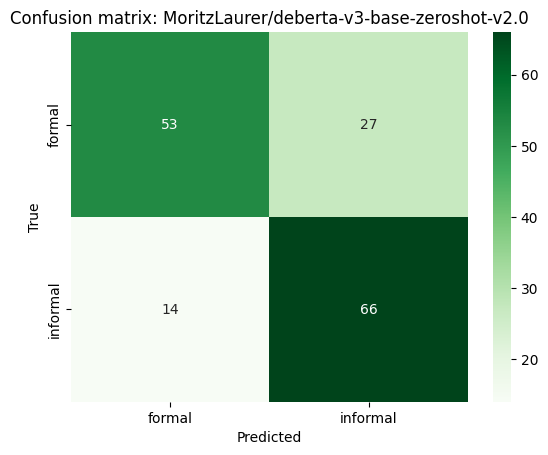

In [34]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_zero_shot_model(model_name, texts, labels, candidate_labels=["formal", "informal"], title_suffix=""):
    clf = pipeline("zero-shot-classification", model=model_name)

    predictions = []
    for text in texts:
        try:
            result = clf(text, candidate_labels=candidate_labels)
            predicted_label = result["labels"][0].lower()
            predictions.append(predicted_label)
        except Exception as e:
            print(f"Failed on: {text[:30]}... Error: {e}")
            predictions.append("error")

    print(f"\n Zero-shot evaluation: {model_name}")
    print(" Accuracy:", accuracy_score(labels, predictions))
    print("\n Classification report:\n", classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions, labels=sorted(set(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix: {title_suffix or model_name}")
    plt.show()

    return predictions


model_name = "MoritzLaurer/deberta-v3-base-zeroshot-v2.0"

preds_zero_shot = evaluate_zero_shot_model(model_name, texts, labels)
